In [1]:
# Import Dependencies and Yahoo Finance API for historical stock data
!pip install yfinance

import yfinance as yf
import os
import json
import pandas as pd


In [2]:
!pip install pandas-datareader
import pandas_datareader as pdr
import datetime

In [3]:
tsla = yf.Ticker("TSLA")
tsla_hist = tsla.history(period="max")

In [4]:
#Display tthe data
tsla_hist.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0
2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0
2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0
2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0
2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0
2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0
2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0
2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0
2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0


In [23]:
tsla_hist_df = tsla_hist
tsla_hist_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,93831500,0,0.0
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500,0,0.0
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000,0,0.0
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000,0,0.0
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500,0,0.0
...,...,...,...,...,...,...,...
2022-07-12,710.539978,719.320007,685.109985,699.210022,29310300,0,0.0
2022-07-13,676.500000,726.179993,675.099976,711.119995,32651500,0,0.0
2022-07-14,704.690002,715.960022,688.000000,714.940002,26185800,0,0.0


In [24]:
tsla_hist_df.to_csv('tsla_hist.csv', sep=',', encoding='utf-8', index=False)

<AxesSubplot:xlabel='Date'>

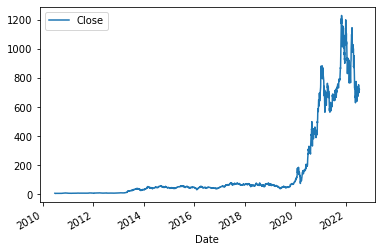

In [5]:
# Visualize microsoft stock prices
tsla_hist.plot.line(y="Close", use_index=True)

# Prep the data

In [6]:
# Confirm the actual closing price
data = tsla_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = tsla_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [7]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
#This is done to avoid leakage in tthe model predicting future priced with future data
tsla_prev = tsla_hist.copy()
tsla_prev = tsla_prev.shift(1)

In [8]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(tsla_prev[predictors]).iloc[1:]
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
2010-06-30,4.766,0.0,4.778,93831500.0,3.800,5.000,3.508
2010-07-01,4.392,0.0,4.766,85935500.0,5.158,6.084,4.660
2010-07-02,3.840,0.0,4.392,41094000.0,5.000,5.184,4.054
2010-07-06,3.222,0.0,3.840,25699000.0,4.600,4.620,3.742
2010-07-07,3.160,0.0,3.222,34334500.0,4.000,4.000,3.166


# Creating a machine learning model

In [9]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [10]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4931506849315068

<AxesSubplot:xlabel='Date'>

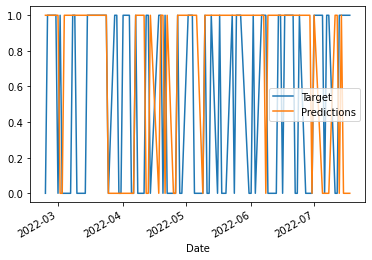

In [11]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

# BACKTESTING


In [12]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [13]:
predictions = backtest(data, model, predictors)

In [14]:
predictions["Predictions"].value_counts()

0.0    1972
1.0      61
Name: Predictions, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5409836065573771

# Improving accuracy

In [16]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [17]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [18]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5532786885245902

In [20]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    1424
1.0     244
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

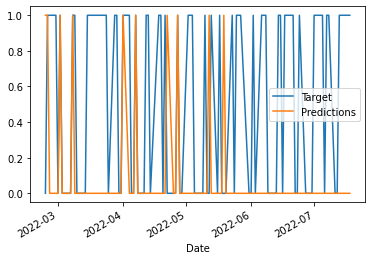

In [21]:
predictions.iloc[-100:].plot()